In [154]:
import pandas as pd 
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMClassifier
import numpy as np
pd.set_option('display.max_columns', 200)

In [310]:
path = '/Users/macintosh/Desktop/data_completitions/Kaggle/2023/icr-identify-age-related-conditions'
df_greeks = pd.read_csv(path+'/greeks.csv')
df_sample_sub = pd.read_csv(path+'/sample_submission.csv')
df_test = pd.read_csv(path+'/test.csv')
df_train = pd.read_csv(path+'/train.csv')

In [311]:
df_greeks.columns = df_greeks.columns.str.lower().str.replace(' ', '')
df_sample_sub.columns = df_sample_sub.columns.str.lower().str.replace(' ', '')
df_test.columns = df_test.columns.str.lower().str.replace(' ', '')
df_train.columns = df_train.columns.str.lower().str.replace(' ', '')

In [312]:
merge_df = df_train.merge(df_greeks, how='left', left_on='id', right_on='id')

In [313]:
# New features
# Alpha
feature_alpha_df = pd.get_dummies(merge_df['alpha'])
feature_alpha_df.columns = 'alpha_'+(feature_alpha_df.columns).str.lower()
# Gamma E, H, A, B flag
feature_gamma_df = pd.get_dummies(merge_df['gamma'])
SELECTED_GAMMA = ['A', 'B', 'E', 'H']
feature_gamma_df = feature_gamma_df.loc[:,SELECTED_GAMMA]
feature_gamma_df.columns = 'gamma_'+(feature_gamma_df.columns).str.lower() 
# Unknown year
merge_df['is_unknown'] = merge_df.epsilon.apply(lambda x: True if x == 'Unknown' else False)

# Concat features
merge_df = pd.concat([merge_df, feature_alpha_df, feature_gamma_df], axis=1)

In [314]:
exclude_cols = ['id','ej', 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'class'
                , 'alpha_a', 'alpha_b', 'alpha_d','alpha_g', 'gamma_a', 'gamma_b', 'gamma_e', 'gamma_h', 'is_unknown']
FEATURES_ALPHA_A = [c for c in merge_df.columns if c not in exclude_cols]

In [315]:
ALL_IDS = merge_df.id.unique()
oof_alpha_a = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])

In [316]:
#Alpha A predict model
# Train with GroupKFold
gkf = GroupKFold(n_splits=5)
model = {}
final_list = []
for i, (train_idx, test_idx) in enumerate(gkf.split(X=merge_df, groups=merge_df.index)):
    print('-'*25)
    print('--- Fold', i+1)
    print('-'*25)
    lgb_params={
        'objective': 'binary',
        'metric': 'auc',
        'learning': 0.002,
        'max_depth': 6,
        'num_iterations':1000
    }
    # Train Data
    train_x = merge_df.iloc[train_idx]
    # train_ids = train_x.id.values
    train_y = merge_df.loc[train_idx]

    # Valid Data
    valid_x = merge_df.iloc[test_idx]
    valid_ids = valid_x.id.values
    valid_y = merge_df.loc[train_idx]

    # Train Model
    clf = LGBMClassifier(**lgb_params)
    clf.fit(train_x[FEATURES_ALPHA_A], train_y['alpha_a'])

    # # Save Model
    model['alpha_a'] = clf
    oof_alpha_a.loc[valid_ids] = clf.predict_proba(valid_x[FEATURES_ALPHA_A])

-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [317]:
actual = oof_alpha_a.copy()
actual['alpha_a'] = merge_df.alpha_a.values

In [318]:
# oof_alpha_a['class_1'].values.reshape((-1))

In [319]:
# Find best threshold
from sklearn.metrics import f1_score
# Find best threshold to convert probs into 1s and 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4, 0.81, 0.01): # np.arange(start, end(but not include), step) 
    # but why use range at 0.4 - 0.8? --> i assume that proper range to identify that good or bad threshold
    print(f'{threshold:.02f}, ', end='')
    preds = (oof_alpha_a['class_1'].values.reshape((-1))>threshold).astype('int') #get all pred values and check if > threshold then true and covert true to int vice versa with false
    m = f1_score(actual['alpha_a'].values.reshape((-1)).astype('int'), preds, average='macro') # make sure that actual & predict same type if not will cause error 
    scores.append(m) # collect data because this use for plot
    thresholds.append(threshold) # collect data because this use for plot
    # this part below just collect best score & threshold
    if m>best_score:
        best_score = m 
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

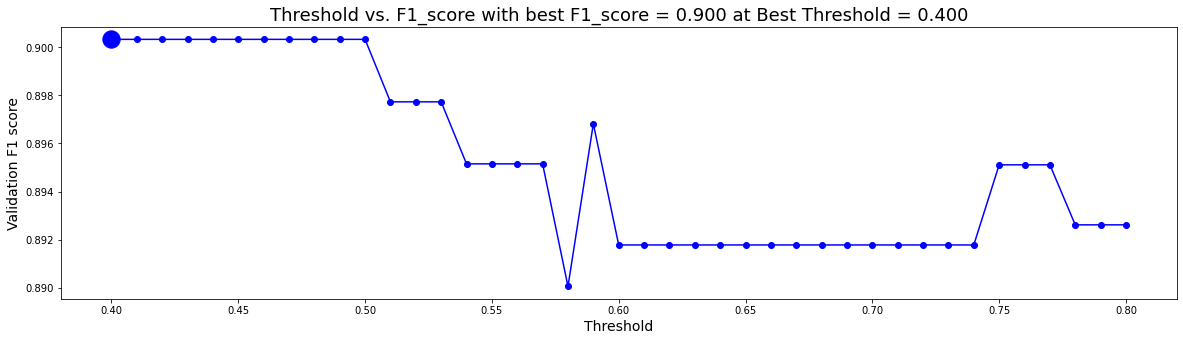

In [320]:
import matplotlib.pylab as plt
# Plot Threshold vs F1 score
plt.figure(figsize=(20,5))
plt.plot(thresholds, scores, '-o', color='blue') # plot all threshold & scores
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1) # make best point are more bigger
plt.xlabel('Threshold', size = 14)
plt.ylabel('Validation F1 score', size = 14)
plt.title(f'Threshold vs. F1_score with best F1_score = {best_score:.3f} at Best Threshold = {best_threshold:.3f}', size = 18)
plt.show()

In [321]:
best_threshold

0.4

In [322]:
# Predict alpha_a feature
oof_alpha_a['alpha_a_flag'] = oof_alpha_a.class_1.apply(lambda x: 1 if x >= 0.55 else 0)
oof_alpha_a = oof_alpha_a.reset_index()

In [323]:
oof_alpha_a[['alpha_a_flag']]

,alpha_a_flag
0,0
1,1
2,1
3,1
4,1
...,...
612,1
613,1
614,1
615,1


In [324]:
merge_df = pd.concat([merge_df, oof_alpha_a[['alpha_a_flag']]], axis=1)

In [325]:
merge_df

,id,ab,af,ah,am,ar,ax,ay,az,bc,bd,bn,bp,bq,br,bz,cb,cc,cd,cf,ch,cl,cr,cs,cu,cw,da,de,df,dh,di,dl,dn,du,dv,dy,eb,ee,eg,eh,ej,el,ep,eu,fc,fd,fe,fi,fl,fr,fs,gb,ge,gf,gh,gi,gl,class,alpha,beta,gamma,delta,epsilon,is_unknown,alpha_a,alpha_b,alpha_d,alpha_g,gamma_a,gamma_b,gamma_e,gamma_h,alpha_a_flag
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019,False,False,True,False,False,False,False,False,False,0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown,True,True,False,False,False,False,False,False,False,1
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown,True,True,False,False,False,False,False,False,False,1
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown,True,True,False,False,False,False,False,False,False,1
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020,False,False,False,True,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.93092

In [326]:

exclude_cols = ['id','ej', 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'class'
                , 'alpha_a', 'alpha_b', 'alpha_d','alpha_g', 'gamma_a', 'gamma_b', 'gamma_e', 'gamma_h', 'is_unknown']
FEATURES = [c for c in merge_df.columns if c not in exclude_cols]
df_tr = merge_df[FEATURES] 
df_tr_label = merge_df[['class']]
# merge_df.head()
# FEATURES

In [327]:
df_tr.head()

,ab,af,ah,am,ar,ax,ay,az,bc,bd,bn,bp,bq,br,bz,cb,cc,cd,cf,ch,cl,cr,cs,cu,cw,da,de,df,dh,di,dl,dn,du,dv,dy,eb,ee,eg,eh,el,ep,eu,fc,fd,fe,fi,fl,fr,fs,gb,ge,gf,gh,gi,gl,alpha_a_flag
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,0
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,1
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,1
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,1
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [328]:
ALL_IDS = merge_df.id.unique()
oof = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])

In [329]:
oof.head()

,class_0,class_1
000ff2bfdfe9,0.0,0.0
007255e47698,0.0,0.0
013f2bd269f5,0.0,0.0
043ac50845d5,0.0,0.0
044fb8a146ec,0.0,0.0


In [330]:
# Train with GroupKFold
gkf = GroupKFold(n_splits=5)
model = {}
final_list = []
for i, (train_idx, test_idx) in enumerate(gkf.split(X=merge_df, groups=merge_df.index)):
    print('-'*25)
    print('--- Fold', i+1)
    print('-'*25)
    lgb_params={
        'objective': 'binary',
        'metric': 'auc',
        'learning': 0.002,
        'max_depth': 6,
        'num_iterations':1000
    }
    # Train Data
    train_x = merge_df.iloc[train_idx]
    # train_ids = train_x.id.values
    train_y = merge_df.loc[train_idx]

    # Valid Data
    valid_x = merge_df.iloc[test_idx]
    valid_ids = valid_x.id.values
    valid_y = merge_df.loc[train_idx]

    # Train Model
    clf = LGBMClassifier(**lgb_params)
    # clf.fit(train_x[FEATURES], train_y['class'])
    clf.fit(train_x[['alpha_a_flag']], train_y['class'])

    # # Save Model
    model['first'] = clf
    # oof.loc[valid_ids] = clf.predict_proba(valid_x[FEATURES])
    oof.loc[valid_ids] = clf.predict_proba(valid_x[['alpha_a_flag']])

-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [331]:
oof.head()

,class_0,class_1
000ff2bfdfe9,0.097222,0.902778
007255e47698,0.940048,0.059952
013f2bd269f5,0.952719,0.047281
043ac50845d5,0.947991,0.052009
044fb8a146ec,0.959524,0.040476


In [332]:
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight=1/nc[y_true], eps=1e-15)

In [333]:
np.bincount(merge_df['class'])

array([509, 108])

In [334]:
y_true = merge_df['class']
y_pred = oof['class_1']
balanced_log_loss(y_true, y_pred)
# Best score is 0.7449367545977311
# now is 6.823326702712194e-06?

0.4571362277653785

In [308]:
df_test[FEATURES]

KeyError: "['is_unknow', 'alpha_a_flag'] not in index"

In [309]:
df_test.head()

,id,ab,af,ah,am,ar,ax,ay,az,bc,bd,bn,bp,bq,br,bz,cb,cc,cd,cf,ch,cl,cr,cs,cu,cw,da,de,df,dh,di,dl,dn,du,dv,dy,eb,ee,eg,eh,ej,el,ep,eu,fc,fd,fe,fi,fl,fr,fs,gb,ge,gf,gh,gi,gl
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
output = df_test[['id']]
output['class_0'] = clf.predict_proba(df_test[FEATURES])[:,0]
output['class_1'] = clf.predict_proba(df_test[FEATURES])[:,1]



/var/folders/wz/ck3sz9r95tv0pwv6x5zcfnw00000gn/T/ipykernel_838/3628133706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['class_0'] = clf.predict_proba(df_test[FEATURES])[:,0]
/var/folders/wz/ck3sz9r95tv0pwv6x5zcfnw00000gn/T/ipykernel_838/3628133706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['class_1'] = clf.predict_proba(df_test[FEATURES])[:,1]


In [111]:
output

,id,class_0,class_1
0,00eed32682bb,0.932913,0.067087
1,010ebe33f668,0.932913,0.067087
2,02fa521e1838,0.932913,0.067087
3,040e15f562a2,0.932913,0.067087
4,046e85c7cc7f,0.932913,0.067087


In [118]:
merge_df.head()

,id,ab,af,ah,am,ar,ax,ay,az,bc,bd,bn,bp,bq,br,bz,cb,cc,cd,cf,ch,cl,cr,cs,cu,cw,da,de,df,dh,di,dl,dn,du,dv,dy,eb,ee,eg,eh,ej,el,ep,eu,fc,fd,fe,fi,fl,fr,fs,gb,ge,gf,gh,gi,gl,class,alpha,beta,gamma,delta,epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


NameError: name 'sns' is not defined